In [54]:
%load_ext autoreload

In [55]:
autoreload 2

In [56]:
import os
import sys
import time
import argparse
import datetime
import math
import pickle
from tqdm import tqdm as tqdm

import torchvision
import torchvision.transforms as transforms

import torch
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from utils import DEVICE

Handle Data

In [57]:
valid_size = 0.1
batch_size = 32
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = torchvision.datasets.MNIST(
                root='../data', 
                train=True,
                download=True, 
                transform=transform)

test_data = torchvision.datasets.MNIST(
                root='../data', 
                train=False,
                download=True, 
                transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size,
                    sampler=train_sampler,
                    num_workers=2)

valid_loader = torch.utils.data.DataLoader(
                    train_data, 
                    batch_size=batch_size, 
                    sampler=valid_sampler, 
                    num_workers=2)

test_loader = torch.utils.data.DataLoader(
                    test_data, 
                    batch_size=batch_size,
                    num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
 #          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = range(10)

(32, 1, 28, 28)


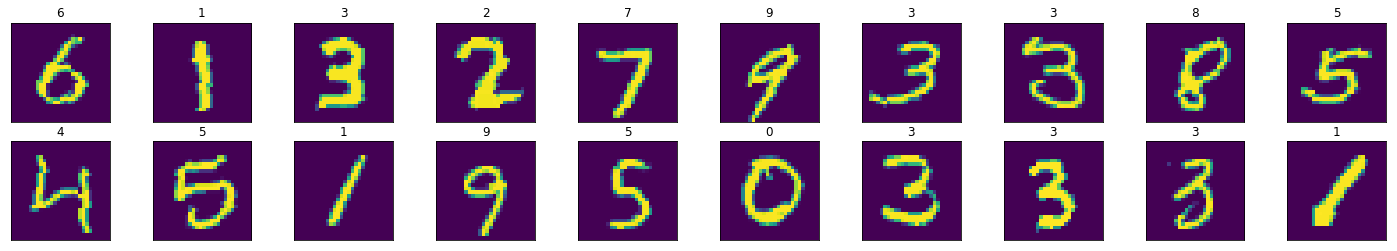

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

    # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0])
    ax.set_title(classes[labels[idx]])

# Define Training functions

## Define how to train a frequentist model

In [59]:
def accuracy(outputs, labels, batch_size = batch_size):
    _, preds = outputs.max(1)
    correct = torch.eq(preds, labels).sum().item()
    return correct/batch_size

In [60]:
def test(model):
    test_accs = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_accs.append(accuracy(outputs, labels))
    return np.mean(test_accs)

In [84]:
def train(name, model, writer, n_epochs = 100):
    optimizer = optim.Adam(model.parameters())
    xent = nn.CrossEntropyLoss()
    model.train()
    m = len(train_loader)
    for epoch in range(n_epochs):
        history = dict(train_acc = [],
                      val_acc = [],
                      xent = [])
        
        # Train
        for batch_id, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            history['train_acc'].append(accuracy(outputs, labels))
            loss = xent(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            history['xent'].append(loss.item())
            print('\rEpoch {0}/{1} \t Batch {2}/{3} \t Cross Entropy: {4}, Train Accuracy: {5}%'.format(
                epoch+1, n_epochs, batch_id, m, history['xent'][-1], 100*history['train_acc'][-1]), end = '')
            
        #Validation
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                history['val_acc'].append(accuracy(outputs, labels))
                
        # Save values
        for key, values in history.items():
            writer.add_scalar('MNIST/{0}/{1}'.format(name, key),
                             np.mean(values), epoch+1)
    return model

## Define how to train a Bayesian Model

In [79]:
def bayes_train(name, model, writer, n_epochs = 100, n_samples = 2):
    model.train()
    m = len(train_loader)
    
    for epoch in range(n_epochs):
        history = dict(train_acc = [],
                       val_acc = [],
                       kl = [],
                       xent = [])
        
        # Train
        for batch_id, (images, labels) in enumerate(train_loader):
            beta = 2 ** (m - (batch_id + 1)) / (2 ** m - 1)
            #beta = 1/m
            
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = [model(images) for _ in range(n_samples)]
            kl, xe, loss = model.step(outputs, labels, beta)
            
            history['train_acc'].append(accuracy(outputs[0], labels))
            history['kl'].append(kl.item()/batch_size)
            history['xent'].append(xe.item()/batch_size)
            print('\rEpoch {0}/{1} \t Batch {2}/{3} \t Cross Entropy: {4}, Train Accuracy: {5}%'.format(
                epoch+1, n_epochs, batch_id, m, history['xent'][-1], 100*history['train_acc'][-1]), end = '')
            
        #Validation
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                history['val_acc'].append(accuracy(outputs, labels))
                
        # Save values
        for key, values in history.items():
            writer.add_scalar('MNIST/{0}/{1}'.format(name, key),
                                 np.mean(values), epoch+1)
    return model

# Define and Train Models

In [51]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
N_EPOCHS = 2

## Frequentist mlp

In [80]:
from utils import Flatten
mlp = lambda n_hidden: nn.Sequential(Flatten(28*28),
            nn.Linear(28*28, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, n_hidden),
            nn.Softplus(),
            nn.Linear(n_hidden, 10))

mlp_net = train('MLP 100', mlp(100), writer, n_epochs = N_EPOCHS)


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 	 Batch 1687/1688 	 Cross Entropy: 0.02684926986694336, Train Accuracy: 50.0%


 50%|█████     | 1/2 [00:07<00:07,  7.31s/it]

Epoch 2/2 	 Batch 1687/1688 	 Cross Entropy: 0.03120894730091095, Train Accuracy: 50.0%


100%|██████████| 2/2 [00:14<00:00,  7.24s/it]

In [67]:
import models

alexnet = train('AlexNet', models.AlexNet(1, 10), writer, n_epochs = N_EPOCHS)


  0%|          | 0/2 [00:00<?, ?it/s]

Cross Entropy: 0.3836577236652374 Train Accuracy: 0.46875


 50%|█████     | 1/2 [02:21<02:21, 141.13s/it]

Cross Entropy: 0.018890127539634705 Train Accuracy: 0.5


100%|██████████| 2/2 [04:46<00:00, 142.50s/it]

## Bayesian MLP

In [88]:
from utils import ScaleMixtureGaussian
from bayes import BayesWrapper

prior_nll = ScaleMixtureGaussian(PI = 0.75,
                                 SIGMA_1 = np.exp(-1),
                                 SIGMA_2 = np.exp(-6))

In [89]:
bayesnet = BayesWrapper(name='BayesMLP 100',
                        net=mlp(100),
                        prior_nll = prior_nll)
bayes_train('Bayes MLP 100', bayesnet, writer, n_epochs = N_EPOCHS, n_samples =2) 

Epoch 2/2 	 Batch 1687/1688 	 Cross Entropy: 0.001667552161961794, Train Accuracy: 50.0%

BayesWrapper(
Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): Softplus(beta=1, threshold=20)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): Softplus(beta=1, threshold=20)
  (5): Linear(in_features=100, out_features=10, bias=True)
))

In [91]:
bayesalexnet = BayesWrapper(name='BayesAlexNet',
                        net=models.AlexNet(1, 10),
                        prior_nll = prior_nll)
bayes_train('Bayes AlexNet 100', bayesalexnet , writer, n_epochs = N_EPOCHS, n_samples =2)  

Epoch 2/2 	 Batch 1687/1688 	 Cross Entropy: 0.002856199163943529, Train Accuracy: 50.0%

BayesWrapper(
AlexNet(
  (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
  (1): Softplus(beta=1, threshold=20)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): Softplus(beta=1, threshold=20)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): Softplus(beta=1, threshold=20)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Softplus(beta=1, threshold=20)
  (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Softplus(beta=1, threshold=20)
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten()
  (14): Linear(in_features=128, out_features=10, bias=True)
))

In [40]:
writer.export_scalars_to_json('all_scalars.json')

Test

In [92]:
print('Accuracy of the network on the 10000 test images: {:.2f} %'.format(
    100 * test(bayesnet)))

Accuracy of the network on the 10000 test images: 95.13 %


In [93]:
print('Accuracy of the network on the 10000 test images: {:.2f} %'.format(
    100 * test(bayesalexnet)))

Accuracy of the network on the 10000 test images: 96.87 %


In [95]:
model = bayesalexnet
test_accs = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = sum([model(images) for _ in range(5)])
        test_accs.append(accuracy(outputs, labels))
print(np.mean(test_accs))

0.9689496805111821


In [96]:
import threading

In [109]:
t0 = time.time()

def f1():
    time.sleep(5)
    a.value += ' ok1: '+str(time.time() - t0)
    
def f2():
    time.sleep(5)
    a.value += ' ok2 '+str(time.time() - t0)
    
t1 = threading.Thread(target = f1)
t2 = threading.Thread(target=f2)
t1.start()
t2.start()
print('started')


started


In [100]:
from ipywidgets import HTML

In [106]:
a = HTML('a')

In [107]:
a

HTML(value='a')

In [103]:
a.value = 'r'